# Hand Positioning

The dataset we will analyze in this notebook is the Hand Positioning data, containing several .csv files for multiple people who were a part of the research conducted.<br>
<b>The Research:</b>
The research comes to analyze behavioural patterns of people. Each person participating in the research was to do three "exercises": Firstly, he/she were to randomly move their hand (and arm) as they wished in any positions. Secondly, two people were put one in front of the other and both were to move their hand and arm as they wished spontaneously. Finally, the two people were to try and synchronize the movement of their hands to match one another (notice that this can be interpreted slightly different by different people). These three tests were recorded for a duration of 75 seconds, by the use of a device called "Leap Motion Controller" (its documentation can be found at the [link](https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html)). This device records (in 60 FPS) multiple characteristics of hands which it detects, for each hand creating a record in the .csv file to be.

The purpose of the notebook and of the research is to perform an analysis of the received data from the device and given a single frame reading of the data from the "Leap Motion Controller", determine in which of the 3 states ("alone", "spontaneous" or "in sync") the 2 people were. Note that the frames we analyze must have 2 hands readings on them. If somehow the device did not detect 2 hands, then the data cannot be used (explained more later in the notebook).<br>
In several instances, the series of tests were conducted twice for a single person. In this case, we shall take only the "most recent" of the tests, when the subject was more comfortable in performing the test. Also, a supplementary dataframe was given to us ("handRight") to fuse with the "alone" dataframes, to help us analyze them in the same way as the other two tests.

At the end we receive multiple .csv files with the data needed. This data has to be processed, united, and then the classifiers must be run to answer the final question of whether it is possible to make such predictions as was asked.

The research paper can be found in the "Data/Hand Positioning" folder of the repository.

In [60]:
#Relevant imports
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import time
from sklearn import metrics
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

## Loading Data and Preproicessing

The preprocessing of the training and the test sets shall be done simultaneously. Care will be taken not to train or fit data from the training set, only transform it in accordance to what was fitted so that the final classifier we decide on can be then tested on this training set.

First, we shall load the datasets from the local drive.

In [2]:
#Training set
sub1Spont = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771052727603804Spontan.csv')
sub1Sync = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771053639929594Sync.csv')
sub1Alone = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771054555711409Alone.csv')

sub2Spont = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759795182793299Spontan.csv')
sub2Sync = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759797397919664Sync.csv')
sub2Alone = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759796290435160Alone.csv')

sub3Spont = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759804404113837Spontan.csv')
sub3Sync = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759806131350399Sync.csv')
sub3Alone = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759805268396661Alone.csv')

sub4Alone = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771082736601528Alone.csv')
sub4Spont = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771083605535985Spontan.csv')
sub4Sync = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771084494502229Sync.csv')

sub5Alone = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770955999435879Alone.csv')
sub5Spont = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770957038873193Spontan.csv')
sub5Sync = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770957894370062Sync.csv')

sub6Spont = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771045591258071Spontan.csv')
sub6Sync = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771046527112972Sync.csv')
sub6Alone = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771047408504303Alone.csv')

sub7Spont = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759787508979097Spontan.csv')
sub7Sync = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759789526313406Sync.csv')
sub7Alone = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759788383205274Alone.csv')

sub8Spont = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771059544754823Spontan.csv')
sub8Sync = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771060699529085Sync.csv')
sub8Alone = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771061659067649Alone.csv')

sub9Spont = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760921663075813Spontan.csv')
sub9Sync = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760923490742912Sync.csv')
sub9Alone = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760922573364655Alone.csv')
#27 dataframes

handRight = pd.read_csv('Data/Hand Positioning/HandRight.csv')

#Final Test Set
sub1TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770940701219076Spontan.csv')
sub1TestSync = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770941638547912Sync.csv')
sub1TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770942529041679Alone.csv')

sub2TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771064635567065Spontan.csv')
sub2TestSync = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771065531910215Sync.csv')
sub2TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771066407626524Alone.csv')

sub3TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754670490266956Spontan.csv')
sub3TestSync = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754671560850581Sync.csv')
sub3TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754669540564461Alone.csv')

Next, we unite each type of test (alone, spontaneous and sync) into separate lists, as the processing of the different types is slightly different. This is done, too, on the final test set. The lengths of the total lists is printed to make sure they are of the correct size.

In [3]:
aloneList = [sub1Alone, sub2Alone, sub3Alone, sub4Alone, sub5Alone, sub6Alone, sub7Alone, sub8Alone, sub9Alone]
syncList = [sub1Sync, sub2Sync, sub3Sync, sub4Sync, sub5Sync, sub6Sync, sub7Sync, sub8Sync, sub9Sync]
spontList = [sub1Spont, sub2Spont, sub3Spont, sub4Spont, sub5Spont, sub6Spont, sub7Spont, sub8Spont, sub9Spont]
totalList = aloneList + syncList + spontList
print (len(totalList))

aloneListTest = [sub1TestAlone, sub2TestAlone, sub3TestAlone]
syncListTest = [sub1TestSync, sub2TestSync, sub3TestSync]
spontListTest = [sub1TestSpont, sub2TestSpont, sub3TestSpont]
totalListTest = aloneListTest + syncListTest + spontListTest
print(len(totalListTest))

27
9


## Preprocessing

To make sure our future classfifiers work correctly, we must make sure there are no NaN values in the dataframes given to us. We can see that there are no such values.

### Checking for NaN

In [4]:
count = 0
for i in range(len(totalList)):
    count += totalList[i].isna().sum().sum()
    
countTest = 0
for i in range(len(totalListTest)):
    countTest += totalListTest[i].isna().sum().sum()
    
count + countTest

0

The column names in the dataframes have spaces in them. This prevents or makes it much more complicated for us to run many functions, so we wish to remove the spaces from the column names. This is done for all data at our disposal, then all sublists are united again into a totalList (this is done several times throughout the notebook).

### Removing spaces from column names

In [5]:
def removeSpaces(someList):
    for i in range(len(someList)):
        someList[i].columns = someList[i].columns.str.replace(' ', '')
    return someList


aloneList = removeSpaces(aloneList)
syncList = removeSpaces(syncList)
spontList = removeSpaces(spontList)
totalList = aloneList + syncList + spontList
    
handRight.columns = handRight.columns.str.replace(' ', '')

aloneListTest = removeSpaces(aloneListTest)
syncListTest = removeSpaces(syncListTest)
spontListTest = removeSpaces(spontListTest)
totalListTest = aloneListTest + syncListTest + spontListTest

### Removing rows with incorrect number of hands

As was mentioned at the start of the notebook, the number of hands detected by the device is not always the correct one. For example, some records in the "sync" section have 1 hand detected, whereas at all times there were 2 people sitting one in front of the other, participating in the experiment. Likewise, in the "alone" section some records detected 2 hands, although only 1 person participated in the recording of the experiment. We want to remove the records where the number of hands detected was incorrect. We first show the unique values in the "#hands" column, to know if we need to notice them differently. This is not the case, as every dataframe has either one unique value (the correct one), or two unique values where one of them is incorrect and has to be removed. We will, anyway, for simplicity's sake, go over all dataframes (even those with only the correct value).<br>
Also, if such records exist in the "alone" dataframes where the hand recorded was the right hand, this, too, is not right, so we remove these records.

In [6]:
#viewing unique values of every dataframe in the "#hands" column
for i in range(len(totalList)):
    print(totalList[i]['#hands'].unique())

[1]
[1 2]
[1]
[1]
[1 2]
[1]
[1]
[1 2]
[1]
[2]
[2]
[2 1]
[2]
[2 1]
[2 1]
[2]
[2 1]
[2]
[2]
[2 1]
[2 1]
[2 1]
[2 1]
[2]
[2]
[2 1]
[2 1]


In [7]:
#removing records with incorrect number of hands
for i in range(len(aloneList)):
    temp = aloneList[i]
    temp = temp[temp['#hands'] == 1]
    aloneList[i] = temp[temp['HandType'] == 'left']
        

for i in range(len(spontList)):
    temp = spontList[i]
    spontList[i] = temp[temp['#hands'] == 2]
    

for i in range(len(syncList)):
    temp = syncList[i]
    syncList[i] = temp[temp['#hands'] == 2]

totalList = aloneList + spontList + syncList

handRight = handRight[handRight['#hands'] == 1]

for i in range(len(aloneListTest)):
    temp = aloneListTest[i]
    temp = temp[temp['#hands'] == 1]
    aloneListTest[i] = temp[temp['HandType'] == 'left']
        

for i in range(len(spontListTest)):
    temp = spontListTest[i]
    spontListTest[i] = temp[temp['#hands'] == 2]
    

for i in range(len(syncListTest)):
    temp = syncListTest[i]
    syncListTest[i] = temp[temp['#hands'] == 2]
    
totalListTest = aloneListTest + syncListTest + spontListTest

Below, we again list the unique values of each dataframe in the "#hands" column, to make sure that the fumction and the code above work as expected.

In [8]:
#checking that the code worked
for i in range(len(totalList)):
    temp = totalList[i]['#hands'].unique()
    print(temp)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


### Correcting handRight

Below, we perform the actions performed on the lists of dataframes above, on the dataframe of handRight, to prepare it for future merging with the lists. The actions performed are: removing records where the recorded hand was categorized as the left hand, where there are NaN values in the dataframe (there are only 34 such values, so it makes little difference whether we remove them or not, so we will not even try to find replacement values for the NaN). We also have to reset the index of the dataframe, as some records were removed, and we wish to keep the indexes continuous, with no gaps.

In [9]:
#Removing all records where the hand recorded was the left hand
handRight = handRight[handRight['HandType'] == 'right']

#Removing all records where there are NaN values (were 34 such)
handRight = handRight.drop(handRight[handRight.isna().any(axis=1)].index)

handRight = handRight.reset_index() #resetting index of the handRight for future merging
handRight = handRight.drop(['index'], axis = 1)

We can notice that the "Time" column of each dataframe does not start with 0, most likely due to the algorithms inside the device used for recording. We want to correct this mistake and subtract the first value in the column from all records, so the first record's time will be 0.0, and the last records time will be very close to 75.

### Removing first 7 seconds from all dataframes

In [10]:
#resetting time in all dfs to start from 0
warnings.filterwarnings('ignore')
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].reset_index() #resetting index of the aloneList
    aloneList[i] = aloneList[i].drop(['index'], axis = 1)
    
    aloneList[i]['Time'] = aloneList[i]['Time'] - aloneList[i].loc[0]['Time']
for i in range(len(spontList)):
    spontList[i]['Time'] = spontList[i]['Time'] - spontList[i].loc[0]['Time']
for i in range(len(syncList)):
    syncList[i]['Time'] = syncList[i]['Time'] - syncList[i].loc[0]['Time']

totalList = aloneList + spontList + syncList
handRight['Time'] = handRight['Time'] - handRight.loc[0]['Time']


for i in range(len(aloneListTest)):
    aloneListTest[i]['Time'] = aloneListTest[i]['Time'] - aloneListTest[i].loc[0]['Time']
for i in range(len(spontListTest)):
    spontListTest[i]['Time'] = spontListTest[i]['Time'] - spontListTest[i].loc[0]['Time']
for i in range(len(syncListTest)):
    syncListTest[i]['Time'] = syncListTest[i]['Time'] - syncListTest[i].loc[0]['Time']

totalListTest = aloneListTest + syncListTest + spontListTest

As specified in the instructions, and due to subjects not being very comfortable in what they are doing, we decide to remove the first 7 seconds of every dataframe from consideration.

In [11]:
#Removing first 7 seconds from each df
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].loc[aloneList[i]['Time'] > 7]
for i in range(len(spontList)):
    spontList[i] = spontList[i].loc[spontList[i]['Time'] > 7]
for i in range(len(syncList)):
    syncList[i] = syncList[i].loc[syncList[i]['Time'] > 7]

handRight = handRight.loc[handRight['Time'] > 7]
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)):
    aloneListTest[i] = aloneListTest[i].loc[aloneListTest[i]['Time'] > 7]
for i in range(len(spontListTest)):
    spontListTest[i] = spontListTest[i].loc[spontListTest[i]['Time'] > 7]
for i in range(len(syncListTest)):
    syncListTest[i] = syncListTest[i].loc[syncListTest[i]['Time'] > 7]

totalListTest = aloneListTest + syncListTest + spontListTest

### Removing duplicates from dataframes

Next, we shall check for and remove any duplicate values in the dataframes.

In [12]:
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].drop_duplicates()
for i in range(len(spontList)):
    spontList[i] = spontList[i].drop_duplicates()
for i in range(len(syncList)):
    syncList[i] = syncList[i].drop_duplicates()

handRight = handRight.drop_duplicates()
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)):
    aloneListTest[i] = aloneListTest[i].drop_duplicates()
for i in range(len(spontListTest)):
    spontListTest[i] = spontListTest[i].drop_duplicates()
for i in range(len(syncListTest)):
    syncListTest[i] = syncListTest[i].drop_duplicates()

totalListTest = aloneListTest + syncListTest + spontListTest

### Combining alone with rightHand

Now that our dataframes are ready, we can merge the "alone" dataframes with that of "handRight". We need to merge them alternatingly (first row from 1 dataframe, then first row from handRight, then second from the dataframe, and so on). Note that "handRight" is not of the same length as the dataframes in "aloneList", so we have to expand it by duplicating it as many times as needed so the number of records matches. To correct any "wholes" in indexes of the dataframes, we reset the index of each of them before the merging, and also after the merge. The aloneList is updated to the merged dataframes.

In [13]:
#Combining alone with RightHand
handRightBigger = handRight
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].reset_index() #resetting index of the aloneList value for merging
    aloneList[i] = aloneList[i].drop(['index'], axis = 1)
    
    handRightBigger = handRight
    while (len(handRightBigger) < len(aloneList[i])): #Expanding the handRight datframe as many times as needed
        handRightBigger = pd.concat([handRightBigger, handRight], ignore_index = True)
    numToDrop = len(handRightBigger) - len(aloneList[i]) #Number of rows to drop from the end of the data to match
    #the length of "df"
    handRightBigger.drop(handRightBigger.tail(numToDrop).index, inplace = True)
    handRightBigger = handRightBigger.reset_index() #resetting index of the handRightBigger for merging
    handRightBigger = handRightBigger.drop(['index'], axis = 1)
    
    aloneList[i] = pd.concat([handRightBigger, aloneList[i]]).sort_index(kind='merge') #merging
    aloneList[i] = aloneList[i].reset_index() #resetting index of the aloneList[i]
    aloneList[i] = aloneList[i].drop(['index'], axis = 1)
    
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)): #Doing the same for final test data.
    aloneListTest[i] = aloneListTest[i].reset_index() #resetting index of the aloneListTest value for merging
    aloneListTest[i] = aloneListTest[i].drop(['index'], axis = 1)
    
    handRightBigger = handRight
    while (len(handRightBigger) < len(aloneListTest[i])): #Expanding the handRight datframe as many times as needed
        handRightBigger = pd.concat([handRightBigger, handRight], ignore_index = True)
    numToDrop = len(handRightBigger) - len(aloneListTest[i]) #Number of rows to drop from the end of the data
    #to match the length of "df"
    handRightBigger.drop(handRightBigger.tail(numToDrop).index, inplace = True)
    handRightBigger = handRightBigger.reset_index() #resetting index of the handRightBigger for merging
    handRightBigger = handRightBigger.drop(['index'], axis = 1)
    
    aloneListTest[i] = pd.concat([handRightBigger, aloneListTest[i]]).sort_index(kind='merge') #merging
    aloneListTest[i] = aloneListTest[i].reset_index() #resetting index of the aloneListTest[i]
    aloneListTest[i] = aloneListTest[i].drop(['index'], axis = 1)

totalListTest = aloneListTest + syncListTest + spontListTest

### Removing instances where FrameID is not unique to 2 records in "sync" and "spontan"

We must make sure that each frame (int the Sync and Spont lists) appears twice. We do this by using the groupby function to group the same FrameID, count them in each group and remove the groups where the count returned anything other than 2.

In [14]:
def removeDuplFrameID(someList):
    for j in range(len(someList)):
        someList[j] = someList[j].reset_index() #resetting index of the someList[j] for future work
        someList[j] = someList[j].drop(['index'], axis = 1)
        
        temp = pd.DataFrame(someList[j].groupby(['FrameID']).count()['Time'])
        temp = temp[temp['Time'] != 2]
        ind = temp.index
        if(len(ind) != 0):
            liqwer = someList[j][someList[j]["FrameID"] == ind[0]]
            for i in range(1, len(ind)):
                liqwer = liqwer + someList[j][someList[j]["FrameID"] == ind[i]]
            ind = liqwer.index
            for i in range(len(ind)):
                someList[j] = someList[j].drop([ind[i]])
    return someList

spontList = removeDuplFrameID(spontList)
syncList = removeDuplFrameID(syncList)
totalList = aloneList + spontList + syncList

spontListTest = removeDuplFrameID(spontListTest)
syncListTest = removeDuplFrameID(syncListTest)
totalListTest = aloneListTest + syncListTest + spontListTest

### Adding labels to data

Our data is almost ready for combination (two actions remain). First of these is the addition of labels to the data. We classify "alone" lists as 0, "spont" as 1 and "sync" as 2 (We are going to have a multiclass problem on our hands).

In [15]:
#Adding labels to data
for i in range(len(aloneList)):
    aloneList[i]['label'] = 0
for i in range(len(spontList)):
    spontList[i]['label'] = 1
for i in range(len(syncList)):
    syncList[i]['label'] = 2
    
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)):
    aloneListTest[i]['label'] = 0
for i in range(len(spontListTest)):
    spontListTest[i]['label'] = 1
for i in range(len(syncListTest)):
    syncListTest[i]['label'] = 2
    
totalListTest = aloneListTest + syncListTest + spontListTest

### Combining every 2 consecutive rows of data

Finally, we need to somehow merge every two consecutive rows into one, as we need our classifiers to compare each left and right hand together, not as two unrelated records. Note that not each time the right hand comes before left hand, or vice versa, so we need to check for each two rows which one is "HandType" == 'right' and which one is left. We decide to do the merge by "moving" the left hand for each of the 2 consecutive rows to the end of the record, essentially doubling the number of features in each dataframe and halving the number of records. To do so, we need to first create a new dataframe with the appropriate names for features (appending "Right" and "Left" respectively to every column's name).<br>
Again, each dataframe uses reset_index to fill any wholes in indexes before the merge (no need to do so after the merge as in the next cell the datasets are merged into one).<br>
Note that the merge works due to us sorting the values by FrameID before the merge on sync and spont lists. It should work in theory even without the merge due to the frames being in increasing order with the passage of time in "Time", but in case of any discrepancies and inaccuracies, we make sure that the values are thus sorted. This assures us that the same frames are next to each other, and thus uniting two rows is uniting the two instances of the same FrameID (the existence of 2 such is assured by previous cells).

In [16]:
for i in range(len(syncList)):    
    syncList[i] = syncList[i].sort_values(by=['FrameID'])
for i in range(len(spontList)):    
    spontList[i] = spontList[i].sort_values(by=['FrameID'])
totalList = aloneList + spontList + syncList
    
for i in range(len(syncListTest)):    
    syncListTest[i] = syncListTest[i].sort_values(by=['FrameID'])
for i in range(len(spontListTest)):    
    spontListTest[i] = spontListTest[i].sort_values(by=['FrameID'])
totalListTest = aloneListTest + syncListTest + spontListTest

In [17]:
#function to combine 2 consecutive rows
start_timeCombine = time.time()
def unite2Rows(someList):
    liR = ["{}{}".format(ind,'Right') for ind in someList[0].columns] #appending "right" to the end of each column name
    liL = ["{}{}".format(ind,'Left') for ind in someList[0].columns]
    LiTotal = liR + liL

    for j in range(len(someList)): #Iterating over every dataframe in the list
        flattenedDf = pd.DataFrame(columns = LiTotal) #empty df
        someList[j] = someList[j].reset_index() #resetting index of the someList[j] for merging
        someList[j] = someList[j].drop(['index'], axis = 1)
        count = 0
        for i in range(0, len(someList[j]), 2): #Iterating over every record in the dataframe with jumps of 2 (due to
            #every iteration using 2 consecutive rows for merging)
            if (someList[j].loc[i]['HandType'] == 'right'):
                right = i
                left = i+1
            else:
                left = i
                right = i+1
            if (someList[j].loc[right]['FrameID'] != someList[j].loc[left]['FrameID']):
                count = count + 1
            rightList = someList[j].loc[right]
            rightList.index = liR

            leftList = someList[j].loc[left]
            leftList.index = liL

            completeRecord = pd.concat([rightList, leftList])
            flattenedDf = flattenedDf.append(completeRecord, ignore_index = True)
        someList[j] = flattenedDf
    return someList


totalList = unite2Rows(totalList)

totalListTest = unite2Rows(totalListTest)

### Merging all dataframes into one

Now we can finally merge all the dataframes into one (and another one for the test data). This is done in the code below by initializing an empty dataframe and using .concat() to append every consecutive dataframe into one.

In [18]:
#Merging all dfs into 1
fulldf = totalList[0]
for i in range(1, len(totalList)):
    fulldf = pd.concat([fulldf, totalList[i]], ignore_index = True)

#Merging all test dfs into 1
fulldfTest = totalListTest[0]
for i in range(1, len(totalListTest)):
    fulldfTest = pd.concat([fulldfTest, totalListTest[i]], ignore_index = True)
    
    
fulldf

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft
0,7.0141,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,7.0311,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,7.0474,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,7.0641,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,7.0807,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101994,74.8080,67304,right,2,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,2
101995,74.8406,67306,right,2,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,2
101996,74.8746,67309,right,2,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,2
101997,74.9073,67311,right,2,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,2


### Exporting/Importing dataframe to local disk

To quicken the runtime on future runs, we export the dataframe received to the local disk, then load it again to make sure that the exportation worked properly (The notebook can be run from here in the future).

In [19]:
fulldf.to_csv('Data/Hand Positioning/df.csv')
fulldfTest.to_csv('Data/Hand Positioning/dfTest.csv')

In [20]:
fulldf = pd.read_csv('Data/Hand Positioning/df.csv')
fulldf = fulldf.drop(['Unnamed: 0'], axis = 1)

fulldfTest = pd.read_csv('Data/Hand Positioning/dfTest.csv')
fulldfTest = fulldfTest.drop(['Unnamed: 0'], axis = 1)

fulldf

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft
0,7.0141,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,7.0311,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,7.0474,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,7.0641,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,7.0807,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101994,74.8080,67304,right,2,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,2
101995,74.8406,67306,right,2,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,2
101996,74.8746,67309,right,2,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,2
101997,74.9073,67311,right,2,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,2


#### Proofing our work

We can next double check that every two labels in the dataframe received (one label of the right hand and one of the left). We expect and receive an empty dataframe, meaning all labels are the same and the merge of 2 consecutive columns worked properly (more tests were run to verify this, but are not shown for the sake of compactness of the notebook).

In [21]:
#Check that all labels in labelLeft and labelRight are the same, hence one can be removed
fulldf[fulldf['labelLeft'] != fulldf['labelRight']]

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft


#### Removing unneeded features

To quicken runtime and reduce noise of future classifiers, we need to remove further unneeded features:
- #hands: no longer needed as it was used already to siphon incorrect data, when the wrong number of hands was identified by the device. Also, this feature would give a significant boost to the classifier to determine if the record is of "alone" or not, as all the alone class has this value of 1, and both other classes have the value 2. This is true for both columns that count the number of hands.
- Time: The time feature is of little to no use for the classifier as it records the amount of time that has passed from the start of the experiment. We have used it to delete first seven seconds of each dataframe but is not needed further.
- FrameID: A unique identifier of each frame is, too, unneeded, as does not provide relevant information for the classifiers.
- HandType: Was used to combine every 2 consecutive rows, now all records in the feature contain the exact same value ("HandTypeRight" == "right", "HandTypeLeft" == "left").

Furthermore, as we delete the label of the right hand, we remain with one label in a row (as we are supposed to). Hence, we can rename the row for further clarity.

In [22]:
fulldf = fulldf.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldf = fulldf.rename(columns={'labelLeft': 'label'})

fulldfTest = fulldfTest.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldfTest = fulldfTest.rename(columns={'labelLeft': 'label'})

fulldf

,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,PitchRight,RollRight,YawRight,WristPosXRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,label
0,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,-0.092033,0.108262,-0.906612,75.45740,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,-0.111674,0.126925,-0.904311,74.46141,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,-0.140004,0.127219,-0.901862,73.60060,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,-0.166623,0.122782,-0.901268,73.19537,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,-0.197763,0.127587,-0.897777,72.68671,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101994,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,0.909181,-1.253298,-0.495629,129.12610,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,2
101995,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,0.983621,-1.239014,-0.525644,129.28680,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,2
101996,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,1.065334,-1.225539,-0.574317,131.85900,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,2
101997,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,1.110287,-1.214715,-0.612753,134.04160,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,2


#### Siphoning data

We can notice that in between 2 frames, not much changes in terms of the characteristics measured. Because of this, and in order to improve the runtime of future models, we can take every nth row instead of every single row. In our case, I believe that taking every 5th record is the best correlation between runtime reduction and accuracy reduction (after several tests, some of which are described later). We do not do this for the test set, as we do not run .fit() on the testing set.

In [23]:
#every 5th row
fulldf = fulldf.iloc[::5, :]

fulldf = fulldf.reset_index() #resetting index of the handRight for merging
fulldf = fulldf.drop(['index'], axis = 1)

In [24]:
fulldfTest = fulldfTest.iloc[::5, :]

fulldfTest = fulldfTest.reset_index() #resetting index of the handRight for merging
fulldfTest = fulldfTest.drop(['index'], axis = 1)

### Correlation graph + Feature manipulation + additional removal of features

Below we create a dataframe of correlations between every attribute with one another. The dataframe represents the linear correlation between the attributes (nonlinear relations have very low values as the functions considers only linear relations). The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). Each attribute has an exact linear relation with itself (1.0000). A final thing to note is that the table presented has many duplicates (we could remove the upper right triangle (if the table were cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).<br>
Using this data, we plot a heatmap using seaborn, to better and easier see the higher values.

<AxesSubplot:>

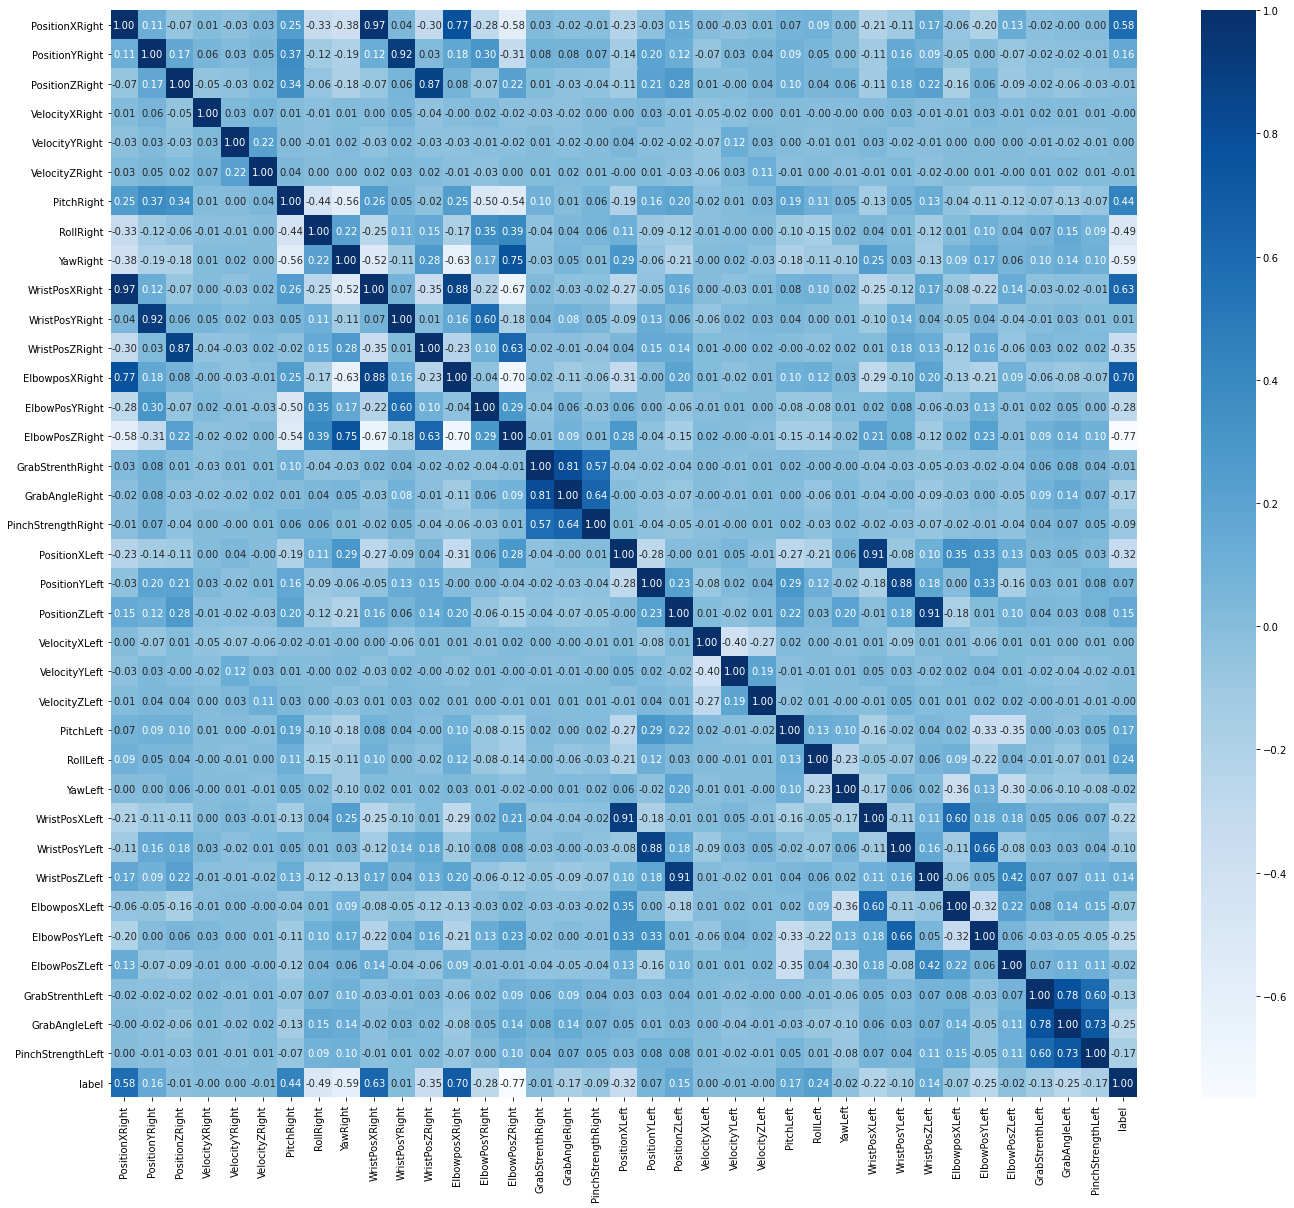

In [25]:
plt.figure(figsize=(23,20))
sns.heatmap(fulldf.corr(), cmap = 'Blues', annot=True, fmt=".2f")

We can see that 4 pairs of features have a correlation of more than 0.9, meaning there is an extremely high linear correlation between the features. Correlations of less than 0.9 were not considered after some tests due to them reducing accuracy by more than 0.5%, while not improving runtime. Regarding the four pairs with very high correlation:
- PositionXRight vs WristPosXRight
- PositionYRight vs WristPosYRight
- PositionXLeft vs WristPosXLeft
- PositionZLeft vs WristPosZLeft

Due to their very high correlation, we can unite these features into one and remove the remaining. We could simply remove one of the features, and the accuracy of the classifiers will not drop significantly, but I believe it best to keep some relation between the pairs. We decide to multiply the values of each pair, thus maintaining some relation between the pairs, and correcting some of the mistakes made by removing one of the features.

In [26]:
#Training set
fulldf['PositionXRight'] = fulldf['PositionXRight'] * fulldf['WristPosXRight']
fulldf['PositionYRight'] = fulldf['PositionYRight'] * fulldf['WristPosYRight']

fulldf['PositionXLeft'] = fulldf['PositionXLeft'] * fulldf['WristPosXLeft']
fulldf['PositionZLeft'] = fulldf['PositionZLeft'] * fulldf['WristPosZLeft']

fulldf = fulldf.drop(['WristPosXRight', 'WristPosYRight', 'WristPosXLeft',
                      'WristPosZLeft'], axis = 1) #Further unneeded attributes

#Test set
fulldfTest['PositionXRight'] = fulldfTest['PositionXRight'] * fulldfTest['WristPosXRight']
fulldfTest['PositionYRight'] = fulldfTest['PositionYRight'] * fulldfTest['WristPosYRight']

fulldfTest['PositionXLeft'] = fulldfTest['PositionXLeft'] * fulldfTest['WristPosXLeft']
fulldfTest['PositionZLeft'] = fulldfTest['PositionZLeft'] * fulldfTest['WristPosZLeft']

fulldfTest = fulldfTest.drop(['WristPosXRight', 'WristPosYRight', 'WristPosXLeft',
                              'WristPosZLeft'], axis = 1) #Further unneeded attributes

### Deeper understanding of data using histograms

Below are the histograms of every attribute and the with the attribute values as the x axis and the number of records with said value in said attribute as the y axis. For our purposes, it is of almost no significance, except to visually understand the approximate distributions of values over the dataframe. This is needed in turn to understand that the data is not "capped" on either end (for example), meaning that the actual values were not rounded to a certain value if they were above that value, and likewise below. Another use for the histograms is seeing that there are sufficient records for most if not all values of every attribute, for example if all of the feature "GrabStrengthRight" or "PinchStrengthRight" were 0 (almost all are 0), there will be no point of that attribute for the model's purposes and could be removed (maybe it is still the case, but it is not as straightforward).

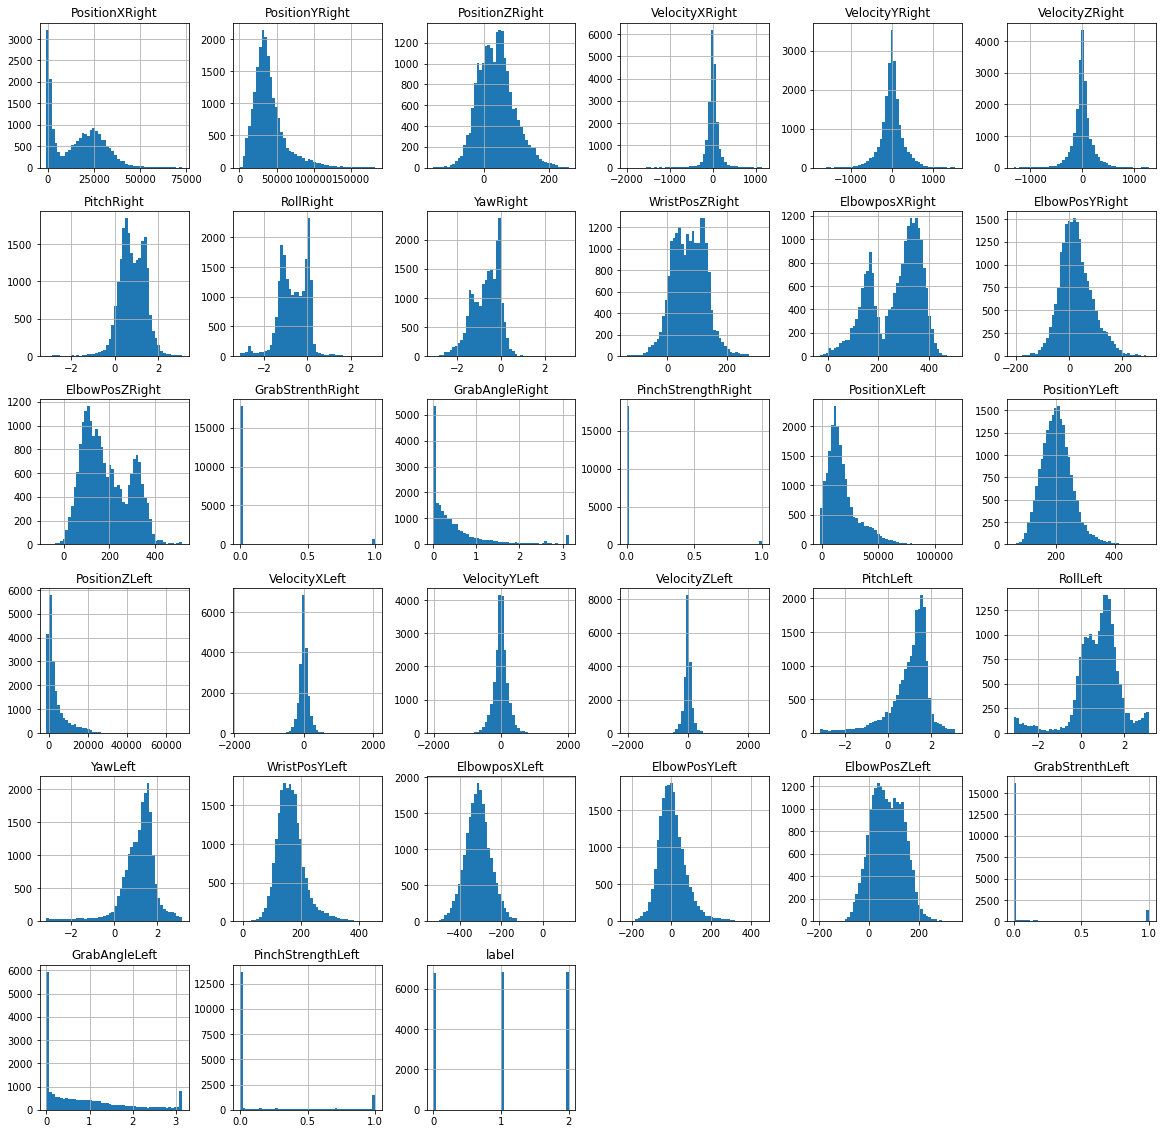

In [27]:
fulldf.hist(bins=50, figsize=(20,20))
plt.show()

As we could see in the histogram above, but an accent should be put on this, the amount of data (records) for each label is almost the same, meaning that we are dealing with balanced data.

In [28]:
print('labels:\n', fulldf['label'].value_counts(), '\n')

labels:
 1    6835
2    6807
0    6758
Name: label, dtype: int64 



### Splitting the data

In preparation for the train_test_split and for the classifiers, we must separate the labels from the training data.

In [29]:
x = fulldf.drop(['label'], axis = 1)
y = fulldf['label']

X_test_final = fulldfTest.drop(['label'], axis = 1)
y_test_final = fulldfTest['label']

As we do not want to introduce bias when constructing and tuning our classifiers, we wish to not touch the testing set right up to the end, after the best classifier was chosen, we shall split the training set itself into a training and testing set (can also be called validation set), on which we shall run and tune our classifiers. We choose the size of both testing sets to be 10% of the data from which it splits, as the 10% are, in my opinion, enough to determine the quality of the classifiers.

The splitting technique itself which we use is the one which is splitting the data as a whole. Another viable and maybe better could be to take one of the subjects of the training set and use him/her as the validation set. This option would show us truer results as the test would be made on a different person, one which the training set did not see previously. Thus, if a classifier was to give a good result on such data, we would expect the final test se show roughly the same accuracy. That said, it would also mean that we lose one out of nine people we have for out training of the classifiers, which is a high percentage in my opinion. This is the main reason why we choose not to do such a splitting but prefer to make the usual train_test_split. We do have to remember though, that the classifiers will perform better for our validation set than they would in "real world" scenarios on other people.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

Next, we need to normalize our data, meaning transforming every value to values in the range [0, 1]. This is done because most (if not all) classifiers expect and work best on such values from 0 to 1. We accomplish this by using the MinMaxScaler() method. The scaling is fitted to the train data, then both the train and the test data are transformed according to what was fitted.

In [31]:
def scale(X_train, X_test, X_test_final):
    min_max_scaler = MinMaxScaler()
    X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values)) #fitting and transforming on train data
    X_test = pd.DataFrame(min_max_scaler.transform(X_test.values)) #only transforming the test and validation sets
    X_test_final = pd.DataFrame(min_max_scaler.transform(X_test_final.values))
    return X_train, X_test, X_test_final

X_train, X_test, X_test_final = scale(X_train, X_test, X_test_final)
X_train.shape

print("The data has", len(X_train.columns), "features")

The data has 32 features


Because Dimensionality reduction should be part of the preprocessing, I shall include the PCA algorithm here, though its results are not used until later in the notebook:

### PCA

The PCA algorithm itself will not be explained in detail in this notebook, and its explanation can be viewed in the "Cats vs Dogs" notebook.

We can see that the number of records in the training set has not changes, whereas the number of features has dropped drastically from 32 to 25! We will check on the performance of the results later in the notebook to be exact, but generally we can say that by covering almost all data, we still manage to reduce the number of features by 7, which can sometimes be the difference between a good and a bad model.

As done in previous notebooks, we shall decide which value to use on the number of components by looking at the cumsum graph. We can see that around 27 or 28 features, the graph is almost exactly at the value of 1, meaning covers all variance. Thus, after choosing a percentage as n_components (0.99 in our case), we can verify that the number of components match to the graph.

In [32]:
def PCAFunc(X_train, X_test, X_test_final, components=None):
    pca = PCA(n_components = components)
    X_train_Reduced = pd.DataFrame(pca.fit_transform(X_train))
    X_test_Reduced = pd.DataFrame(pca.transform(X_test))
    X_test_final_Reduced = pd.DataFrame(pca.transform(X_test_final))
    return X_train_Reduced, X_test_Reduced, X_test_final_Reduced, pca

X_train_Reduced, X_test_Reduced, X_test_final_Reduced, pca = PCAFunc(X_train, X_test, X_test_final)

X_train_Reduced.shape

(18360, 32)

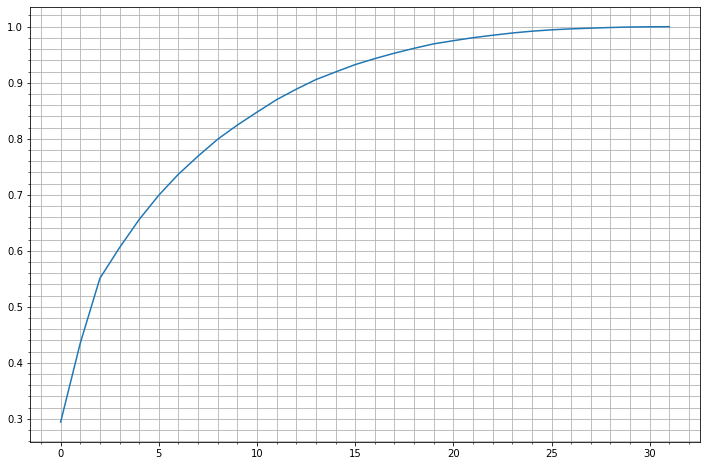

In [33]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12,8))
plt.plot(cumsum)
plt.minorticks_on()
plt.grid(which = 'both')

In [34]:
X_train_Reduced, X_test_Reduced, X_test_final_Reduced, pca = PCAFunc(X_train, X_test, X_test_final, 0.99)

We have finished the step of preprocessing for our data. We could continue to delve deeper into the understanding of data through graphs, trying to figure out how we could take less data while receiving similar results. We choose not to do this due to two reasons, the first being: if we find some useful information regarding classification of records to the wanted classes, it would be our understanding of the data that helps us classify the records, which, as stated several times, is a bias of sorts, as humans and machines do not think alike. The second reason is that the classifiers perform the job of understanding data themselves, in one way or another, so in some ways it may be impractical to do so, as the variance of data may help the classifiers perform their job properly and with high accuracy.

## Classifiers

For Each classifier, besides the explanation as to how the classifier performs its job (briefly), a confusion matrix and a classification report are added in order to help us judge the classifier's performance. What exactly the matrix and the report show us is explained in detail in the "Airline Satisfaction" notebook.<br>

First, the simple classifiers are run, then more advanced such as the ones using ensemble learning.

We currently do not use PCA, as the current number of features of the data is only 32. We will do so later and show the comparison between the models.

### Dummy Classifier

Before choosing and applying the models to the data, we need a baseline classifier, to compare all others to it: if the classifiers thereafter are worse than the base classifier, we are doing something wrong. If the classifier is better than the base classifier, on the other hand, it means that the model works, and can be better at predicting than a "dummy" classifier. The base classifier we will use is <b>Dummy Classifier</b>, which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.

Accuracy (Dummy):  0.3107843137254902
Time taken to achive result: 0.000997781753540039 seconds
              precision    recall  f1-score   support

           0       0.31      1.00      0.47       634
           1       0.00      0.00      0.00       722
           2       0.00      0.00      0.00       684

    accuracy                           0.31      2040
   macro avg       0.10      0.33      0.16      2040
weighted avg       0.10      0.31      0.15      2040



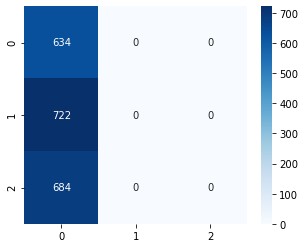

In [35]:
#Dummy
def dummy(X_train, y_train, X_test, y_test):
    import time
    start_timeDummy = time.time()
    dummyModel = DummyClassifier(strategy="most_frequent")
    dummyModel.fit(X_train, y_train)
    predictionsDummy = dummyModel.predict(X_test)

    accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
    print("Accuracy (Dummy): ", accuracyDummy)
    timeDummy = time.time() - start_timeDummy
    print("Time taken to achive result: %s seconds" % (timeDummy))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsDummy, zero_division = 0))
    sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')
    return dummyModel, predictionsDummy, accuracyDummy, timeDummy
    
dummyModel, predictionsDummy, accuracyDummy, timeDummy = dummy(X_train, y_train, X_test, y_test)

### KNN Classifier

We will first use the <b>KNN classifier</b>. The KNN classifier (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.

Accuracy (KNN):  0.9857843137254902
Time taken to achive result: 0.38295793533325195 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.98      0.98      0.98       722
           2       0.98      0.98      0.98       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



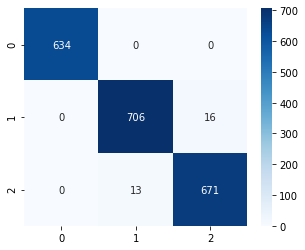

In [36]:
#KNN
def knn(X_train, y_train, X_test, y_test):
    import time
    start_timeKNN = time.time()
    modelKNN = KNeighborsClassifier(n_neighbors = 2, weights='distance')
    modelKNN.fit(X_train, y_train)
    predictionsKNN = modelKNN.predict(X_test)
    accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN)
    print("Accuracy (KNN): ", accuracyKNN)
    timeKNN = time.time() - start_timeKNN
    print("Time taken to achive result: %s seconds" % (timeKNN))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsKNN))
    sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')
    return modelKNN, predictionsKNN, accuracyKNN, timeKNN
    
modelKNN, predictionsKNN, accuracyKNN, timeKNN = knn(X_train, y_train, X_test, y_test)

### Logistic Regression Classifier

For our second classifier we will choose <b>Logistic Regression</b>. This classifier is chosen because it makes no assumptions regarding the distribution of labels, it works according to probabilities which it calculates for each record in the dataframe, and it is a fairly simple classifier that yet works well with many datasets. The classifier tries to fit an S shape to the data (as opposed to linear regression that fits a straight line), where the edges of the S are values where the probability is very high for a label to occur, and closer to the middle of the S, it is lower. We can also set a threshold "on the S", from which the classifier will predict a certain value. This is usually done when a certain value is preferred over the other. As we try to be objective with the reviews, we will not do it.

Accuracy (Logistic Regression):  0.8769607843137255
Time taken to achive result: 0.4198775291442871 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       634
           1       0.82      0.84      0.83       722
           2       0.83      0.80      0.82       684

    accuracy                           0.88      2040
   macro avg       0.88      0.88      0.88      2040
weighted avg       0.88      0.88      0.88      2040



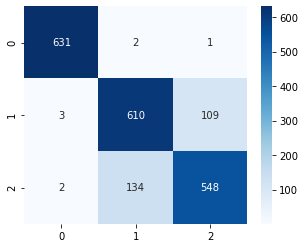

In [37]:
#Logistic Regression
def logReg(X_train, y_train, X_test, y_test):
    import time
    start_timeLogReg = time.time()
    modelLogReg = LogisticRegression()
    modelLogReg.fit(X_train, y_train)
    predictionsLogReg = modelLogReg.predict(X_test)
    accuracyLogReg = modelLogReg.score(X_test, y_test)
    print("Accuracy (Logistic Regression): ", accuracyLogReg)
    timeLogReg = time.time() - start_timeLogReg
    print("Time taken to achive result: %s seconds" % (timeLogReg))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsLogReg))
    sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')
    return modelLogReg, predictionsLogReg, accuracyLogReg, timeLogReg

modelLogReg, predictionsLogReg, accuracyLogReg, timeLogReg = logReg(X_train, y_train, X_test, y_test)

### Gaussian Naive Bayes

Before we start with the models using Ensemble learning though, we would like to try using a classifier called <b>Gaussian Naive Bayes</b>. This classifier uses the Gaussian distribution to help it classify records. By calculating the likelihoods for each feature on whether it is of one class or another and multiplying these likelihoods for all classes (in our case 3), the classifier does its work. Note that it takes into account the imbalanced data as the default priors for each class (calculated by the classifier).

Accuracy (XGBoost):  0.8294117647058824
Time taken to achive result: 0.012970209121704102 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       634
           1       0.78      0.73      0.76       722
           2       0.73      0.79      0.76       684

    accuracy                           0.83      2040
   macro avg       0.84      0.84      0.83      2040
weighted avg       0.83      0.83      0.83      2040



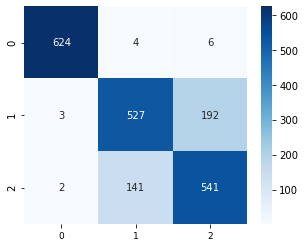

In [61]:
#Gaussian Naive Bayes
def gnb(X_train, y_train, X_test, y_test):
    start_timeGaussianNB = time.time()
    modelGNB = GaussianNB()
    modelGNB.fit(X_train, y_train)
    predictionsGNB = modelGNB.predict(X_test)
    accuracyGNB = metrics.accuracy_score(y_test, predictionsGNB)
    print("Accuracy (XGBoost): ", accuracyGNB)
    timeGNB = time.time() - start_timeGaussianNB
    print("Time taken to achive result: %s seconds" % (timeGNB))
    
    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsGNB))
    sns.heatmap(confusion_matrix(y_test, predictionsGNB), cmap = "Blues", annot=True, fmt = '.0f')
    return modelGNB, predictionsGNB, accuracyGNB, timeGNB

modelGNB, predictionsGNB, accuracyGNB, timeGNB = gnb(X_train, y_train, X_test, y_test)

### Random Forests Classifier

We can now move on to more advanced models that use Ensemble Learning (the concept is explained in detail in the "Airline Satisfaction" notebook). The first one of these shall be the <b>Random Forests</b> Classifier. This classifier uses ensemble learning by constructing a multitude of decision trees (specified with the n_estimators hyperparameter, defaults at 100), without a maximum depth of each tree (such depth can be added using the max_depth hyperparameter, but after several tests, the result was that not limiting the trees is best in the case of this data). After several tests, the number of estimators was set to 200, as the best correlation of accuracy to time and resource consumption.<br>
For the test set, each trees prediction is calculated, the results then aggregated, and the final answer is given. The aggregation is performed by each trees result counted and the "majority vote" is the final answer of the classifier.

Accuracy (Random Forests):  0.9857843137254902
Time taken to achive result: 1.340663194656372 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.98      0.98      0.98       722
           2       0.98      0.98      0.98       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



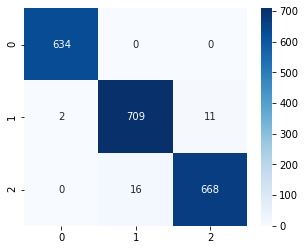

In [38]:
#Random Forests
def randForests(X_train, y_train, X_test, y_test):
    import time
    start_timeRandForests = time.time()
    modelRandForests = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = 0)
    modelRandForests.fit(X_train, y_train)
    predictionsRandForests = modelRandForests.predict(X_test)
    accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
    print("Accuracy (Random Forests): ", accuracyRandForests)
    timeRandForests = time.time() - start_timeRandForests
    print("Time taken to achive result: %s seconds" % (timeRandForests))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsRandForests))
    sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')
    return modelRandForests, predictionsRandForests, accuracyRandForests, timeRandForests

modelRandForests, predictionsRandForests, accuracyRandForests, timeRandForests = randForests(X_train,
                                                                                             y_train, X_test, y_test)

### AdaBoost Classifier

Next, we will check the performance of the <b>AdaBoost Classifier</b> (AdaBoost stands for Adaptive Boost). This classifier also uses ensemble learning, as well as boosting, to achieve its purpose. After receiving the results from some base classifier, in our case the Random Forests Classifier, the model then performs the base classifier over and over (n_estimator times), while each time giving more weight to the misclassified training instances. Then, again using ensemble learning techniques the model returns its final answer according to the many sub-models it created.<br>
The learning rate hyperparameter set to 0.1 (defaults at 1) after several tests to determine the best value. The hyperparameter specifies the rate of adaptability of the classifier to the data after each iteration of the estimator.

Accuracy (AdaBoost):  0.9852941176470589
Time taken to achive result: 1.412658929824829 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.98      0.98      0.98       722
           2       0.98      0.98      0.98       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



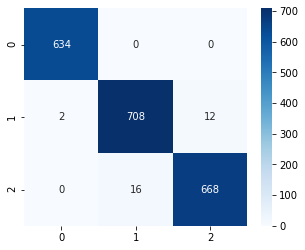

In [39]:
#AdaBoost
def adaBoost(X_train, y_train, X_test, y_test):
    import time
    start_timeAdaBoost = time.time()
    modelAdaBoost = AdaBoostClassifier(modelRandForests, n_estimators = 200, random_state = 0, learning_rate = 0.1)
    modelAdaBoost.fit(X_train, y_train)
    predictionsAdaBoost = modelAdaBoost.predict(X_test)
    accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
    print("Accuracy (AdaBoost): ", accuracyAdaBoost)
    timeAdaBoost = time.time() - start_timeAdaBoost
    print("Time taken to achive result: %s seconds" % (timeAdaBoost))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsAdaBoost))
    sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')
    return modelAdaBoost, predictionsAdaBoost, accuracyAdaBoost, timeAdaBoost

modelAdaBoost, predictionsAdaBoost, accuracyAdaBoost, timeAdaBoost = adaBoost(X_train, y_train, X_test, y_test)

### XGBoost Classifier

Last of the single models (but certainly not least), we shall run the <b>XGBoost Classifier</b> on our data (XGBoost standing for Extreme Gradient Boosting, which uses Ensemble Learning and boosting in a similar yet different way to AdaBoost above. Where AdaBoost tweaks the individual instance weights, giving some more or less weight, XGBoost fits a new predictor to the residual errors made by the previous predictor. It should be noted that the residual errors get smaller with each iteration of XGBoost, making the model very effective (in many cases the most effective out of all).

After several tests, the number of estimators was set to 4000, with the learning rate of 0.5, with no limitation of depth, as the best correlation of efficiency of the classifier. Note that after the dropping of the 4 features after the correlation graph, the accuracy dropped by 0.3%. Although not of much significance, due to the very minor change in runtime, might be of use (we will consider this more later).

Accuracy (XGBoost):  0.9901960784313726
Time taken to achive result: 25.30731725692749 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.99      0.98      0.99       722
           2       0.98      0.99      0.99       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



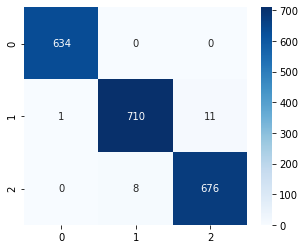

In [40]:
#XGBoost
def XGBoost(X_train, y_train, X_test, y_test):
    import time
    start_timeXGBoost = time.time()
    modelXGBoost = XGBClassifier(learning_rate = 0.5,
                                 n_estimators = 4000,
                                 verbosity = 0,
                                 use_label_encoder = False,
                                 n_jobs = -1)
    modelXGBoost.fit(X_train, y_train)
    predictionsXGBoost = modelXGBoost.predict(X_test)
    accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
    print("Accuracy (XGBoost): ", accuracyXGBoost)
    timeXGBoost = time.time() - start_timeXGBoost
    print("Time taken to achive result: %s seconds" % (timeXGBoost))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsXGBoost))
    sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')
    return modelXGBoost, predictionsXGBoost, accuracyXGBoost, timeXGBoost
    
modelXGBoost, predictionsXGBoost, accuracyXGBoost, timeXGBoost = XGBoost(X_train, y_train, X_test, y_test)

### Voting Classifier

Now that all models are trained, and they are not bad, we can try to combine them and get "the best out of all worlds". This we shall first try by using the <b>Voting Classifier</b>. This classifier takes the results of each model (given in the "estimators" hyperparameter), and compares the results given by each model for every record of the dataframe, returning the value which most classifiers agree on. The voting method was changed to "soft", meaning that from each classifier, the probability of each result will be considered ("how sure the classifier is that its final decision is correct"), rather than the raw "yes or no" in the case of "hard" voting method. The weights of each model in the evaluation are also given, for we know that Logistic Regression had much lower accuracy than all the others, while XGBoost was slightly better than the others.

Accuracy (Voting):  0.9926470588235294
Time taken to achive result: 31.098904848098755 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.99      0.99      0.99       722
           2       0.99      0.99      0.99       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



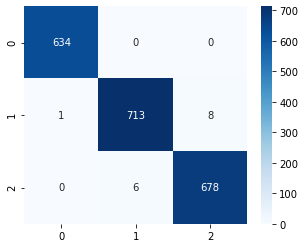

In [41]:
#Voting
def voting(X_train, y_train, X_test, y_test):
    import time
    start_timeVoting = time.time()
    modelVoting = VotingClassifier(
        estimators=
            [('KNN', modelKNN),
             ('LogReg', modelLogReg),
             ('RandForests', modelRandForests),
             ('AdaBoost', modelAdaBoost),
             ('XGBoost', modelXGBoost)],
        voting='soft', n_jobs=-1, weights=[3, 1, 3, 3, 4])
    modelVoting.fit(X_train, y_train)
    predictionsVoting = modelVoting.predict(X_test)
    accuracyVoting = metrics.accuracy_score(y_test, predictionsVoting)
    print("Accuracy (Voting): ", accuracyVoting)
    timeVoting = time.time() - start_timeVoting
    print("Time taken to achive result: %s seconds\n\n" % (timeVoting))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsVoting))
    sns.heatmap(confusion_matrix(y_test, predictionsVoting), cmap = "Blues", annot=True, fmt = '.0f')
    return modelVoting, predictionsVoting, accuracyVoting, timeVoting

modelVoting, predictionsVoting, accuracyVoting, timeVoting = voting(X_train, y_train, X_test, y_test)

### Bagging and Pasting Classifiers

Another option we will now observe is to use the <b>Bagging/Pasting Classifiers</b>. These classifiers combine not many different models, but a single model where the data is divided into multiple parts (the number is defined in the n_estimators hyperparameter), and a single model is run on all these subsections, resulting in a quite accurate model. When the samples taken from the complete dataset can be chosen twice or more for a single predictor, the model is called Bagging, if not then it is Pasting. In practice, Pasting is used more when the dataset is large, while for smaller datasets, the Bagging Classifier may be a good choice. We will try to use both classifiers to see how it performs on our data. The difference between the two classifiers in code is only the "bootstrap" hyperparameter. We will Use the XGBoost calssifier as the estimator, as it performed best out of the classifiers we have evaluated up to this point, but we shall reduce the number of estimators in each XGBoost run to reduce runtime.

#### Bagging Classifier

Accuracy:  0.986764705882353
Time taken to achive result: 619.7072765827179 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.99      0.98      0.98       722
           2       0.98      0.98      0.98       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



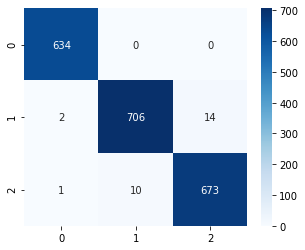

In [42]:
#Bagging
def baggingPasting(X_train, y_train, X_test, y_test, bootstrapVal):
    import time
    modelXGBoostNew = XGBClassifier(learning_rate = 0.5, n_estimators = 400, verbosity = 0, use_label_encoder = False,
                                 n_jobs = -1)
    start_timeBagging = time.time()
    warnings.filterwarnings('ignore')
    modelBagging = BaggingClassifier(modelXGBoostNew, n_estimators = 100, bootstrap = bootstrapVal)
    modelBagging.fit(X_train, y_train)
    predictionsBagging = modelBagging.predict(X_test)
    accuracyBagging = metrics.accuracy_score(y_test, predictionsBagging)
    print("Accuracy: ", accuracyBagging)
    timeBagging = time.time() - start_timeBagging
    print("Time taken to achive result: %s seconds\n\n" % (timeBagging))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsBagging))
    sns.heatmap(confusion_matrix(y_test, predictionsBagging), cmap = "Blues", annot=True, fmt = '.0f')
    return modelBagging, predictionsBagging, accuracyBagging, timeBagging

modelBagging, predictionsBagging, accuracyBagging, timeBagging = baggingPasting(X_train, y_train, X_test, y_test, True)

#### Pasting Classifier

Accuracy:  0.9897058823529412
Time taken to achive result: 675.0112235546112 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.99      0.98      0.99       722
           2       0.98      0.99      0.99       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



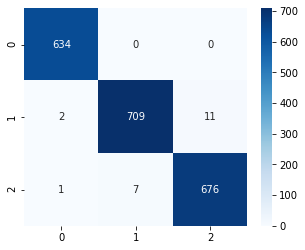

In [43]:
modelPasting, predictionsPasting, accuracyPasting, timePasting = baggingPasting(X_train, y_train, X_test, y_test, False)

### Stacking Classifier


The last ensemble method we will evaluate is the <b>Stacking Classifier</b>. This uses the simple yet elegant idea to take the results given by each predictor for each method, and unlike the voting classifier, build a new model to evaluate them and return an answer, which shall be the final result for the instance for this classifier.

Accuracy (Stacking):  0.9955882352941177
Time taken to achive result: 153.43012714385986 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       1.00      0.99      0.99       722
           2       0.99      1.00      0.99       684

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



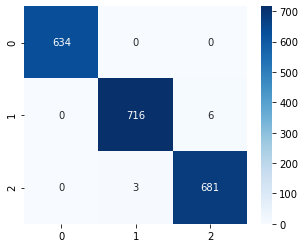

In [44]:
#Stacking
def stacking(X_train, y_train, X_test, y_test):
    import time
    start_timeStacking = time.time()
    warnings.filterwarnings('ignore')
    modelStacking = StackingClassifier(estimators= [('KNN', modelKNN),
                                          ('LogReg', modelLogReg),
                                          ('RandForests', modelRandForests),
                                          ('AdaBoost', modelAdaBoost),
                                          ('XGBoost', modelXGBoost)], 
                             final_estimator = modelXGBoost)
    modelStacking.fit(X_train, y_train)
    predictionsStacking = modelStacking.predict(X_test)
    accuracyStacking = metrics.accuracy_score(y_test, predictionsStacking)
    print("Accuracy (Stacking): ", accuracyStacking)
    timeStacking = time.time() - start_timeStacking
    print("Time taken to achive result: %s seconds\n\n" % (timeStacking))

    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsStacking))
    sns.heatmap(confusion_matrix(y_test, predictionsStacking), cmap = "Blues", annot=True, fmt = '.0f')
    return modelStacking, predictionsStacking, accuracyStacking, timeStacking

modelStacking, predictionsStacking, accuracyStacking, timeStacking = stacking(X_train, y_train, X_test, y_test)

### Models run on data with the use of PCA

Accuracy (KNN):  0.9848039215686275
Time taken to achive result: 0.3638453483581543 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.98      0.98      0.98       722
           2       0.98      0.98      0.98       684

    accuracy                           0.98      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.98      0.98      0.98      2040



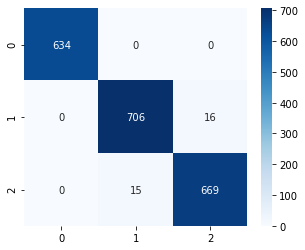

In [45]:
modelKNNPCA, predictionsKNNPCA, accuracyKNNPCA, timeKNNPCA = knn(X_train_Reduced, y_train, X_test_Reduced, y_test)

Accuracy (Logistic Regression):  0.8691176470588236
Time taken to achive result: 0.40010547637939453 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       634
           1       0.80      0.84      0.82       722
           2       0.82      0.78      0.80       684

    accuracy                           0.87      2040
   macro avg       0.87      0.87      0.87      2040
weighted avg       0.87      0.87      0.87      2040



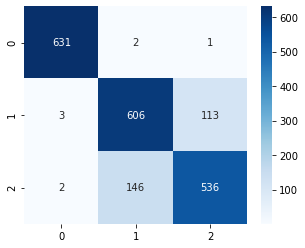

In [46]:
modelLogRegPCA, predictionsLogRegPCA, accuracyLogRegPCA, timeLogRegPCA = logReg(X_train_Reduced,
                                                                                y_train, X_test_Reduced, y_test)

Accuracy (XGBoost):  0.8200980392156862
Time taken to achive result: 0.013974905014038086 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       634
           1       0.76      0.74      0.75       722
           2       0.73      0.75      0.74       684

    accuracy                           0.82      2040
   macro avg       0.83      0.83      0.83      2040
weighted avg       0.82      0.82      0.82      2040



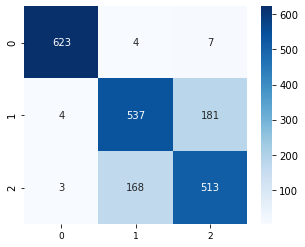

In [62]:
modelGNBPCA, predictionsGNBPCA, accuracyGNBPCA, timeGNBPCA = gnb(X_train_Reduced, y_train, X_test_Reduced, y_test)

Accuracy (Random Forests):  0.9642156862745098
Time taken to achive result: 1.5909209251403809 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.94      0.96      0.95       722
           2       0.96      0.94      0.95       684

    accuracy                           0.96      2040
   macro avg       0.97      0.97      0.97      2040
weighted avg       0.96      0.96      0.96      2040



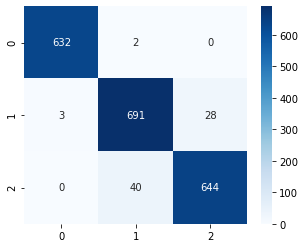

In [47]:
modelRandForestsPCA, predictionsRandForestsPCA, accuracyRandForestsPCA, timeRandForestsPCA = randForests(X_train_Reduced,
                                                                                                         y_train,
                                                                                                         X_test_Reduced,
                                                                                                         y_test)

Accuracy (AdaBoost):  0.9651960784313726
Time taken to achive result: 1.6787350177764893 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.94      0.96      0.95       722
           2       0.97      0.94      0.95       684

    accuracy                           0.97      2040
   macro avg       0.97      0.97      0.97      2040
weighted avg       0.97      0.97      0.97      2040



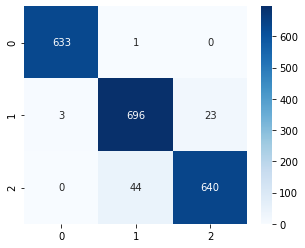

In [48]:
modelAdaBoostPCA, predictionsAdaBoostPCA, accuracyAdaBoostPCA, timeAdaBoostPCA = adaBoost(X_train_Reduced,
                                                                                          y_train, X_test_Reduced, y_test)

Accuracy (XGBoost):  0.9769607843137255
Time taken to achive result: 32.07579851150513 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.97      0.97      0.97       722
           2       0.97      0.97      0.97       684

    accuracy                           0.98      2040
   macro avg       0.98      0.98      0.98      2040
weighted avg       0.98      0.98      0.98      2040



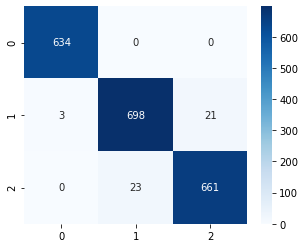

In [49]:
modelXGBoostPCA, predictionsXGBoostPCA, accuracyXGBoostPCA, timeXGBoostPCA = XGBoost(X_train_Reduced, y_train,
                                                                                     X_test_Reduced, y_test)

Accuracy (Voting):  0.9833333333333333
Time taken to achive result: 36.83998155593872 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.98      0.98      0.98       722
           2       0.98      0.97      0.98       684

    accuracy                           0.98      2040
   macro avg       0.98      0.98      0.98      2040
weighted avg       0.98      0.98      0.98      2040



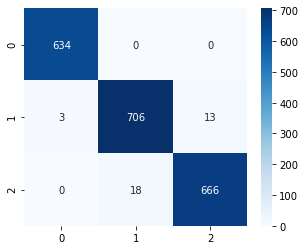

In [50]:
modelVotingPCA, predictionsVotingPCA, accuracyVotingPCA, timeVotingPCA = voting(X_train_Reduced, y_train,
                                                                                 X_test_Reduced, y_test)

Accuracy:  0.975
Time taken to achive result: 789.8874773979187 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.97      0.96      0.96       722
           2       0.96      0.97      0.96       684

    accuracy                           0.97      2040
   macro avg       0.98      0.98      0.98      2040
weighted avg       0.97      0.97      0.97      2040



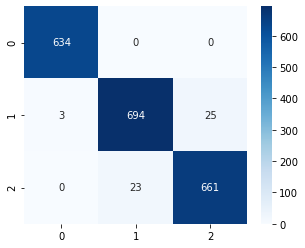

In [51]:
modelBaggingPCA, predictionsBaggingPCA, accuracyBaggingPCA, timeBaggingPCA = baggingPasting(X_train_Reduced, y_train,
                                                                                            X_test_Reduced, y_test, True)

Accuracy:  0.9789215686274509
Time taken to achive result: 865.2716310024261 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.97      0.97      0.97       722
           2       0.97      0.97      0.97       684

    accuracy                           0.98      2040
   macro avg       0.98      0.98      0.98      2040
weighted avg       0.98      0.98      0.98      2040



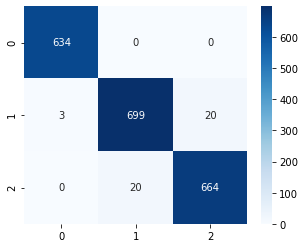

In [52]:
modelPastingPCA, predictionsPastingPCA, accuracyPastingPCA, timePastingPCA = baggingPasting(X_train_Reduced, y_train,
                                                                                            X_test_Reduced, y_test, False)

Accuracy (Stacking):  0.9887254901960785
Time taken to achive result: 187.3762562274933 seconds


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       0.99      0.98      0.98       722
           2       0.98      0.99      0.98       684

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



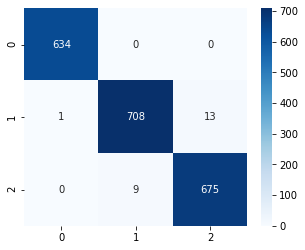

In [53]:
modelStackingPCA, predictionsStackingPCA, accuracyStackingPCA, timeStackingPCA = stacking(X_train_Reduced, y_train,
                                                                                          X_test_Reduced, y_test)

## Classifier Evaluation

### Evaluation of current classifiers

In order to better understand our classifiers, and especially the difference between the ones using PCA and the ones not using PCA, we shall plot an "accuracies" bar graph with 2 bar groups: one representing the classifier before PCA and one after (for each classifier). We have to remember two things. First, we expect the accuracies to drop while using PCA, and the question that we have to ask is not dependent on the accuracy only, but rather on the combination of accuracy vs runtime which will be presented next. The PCA used covered 99% of all variance, meaning that the drop in accuracy presented below is the minimal drop, while the drop in runtime is also minimal. We can see from this graph, that, excluding KNN from consideration, the difference in accuracy between the classifiers is at least 0.5%. For such a high percentage of variance, it is my opinion that the drop in accuracy is very significant.

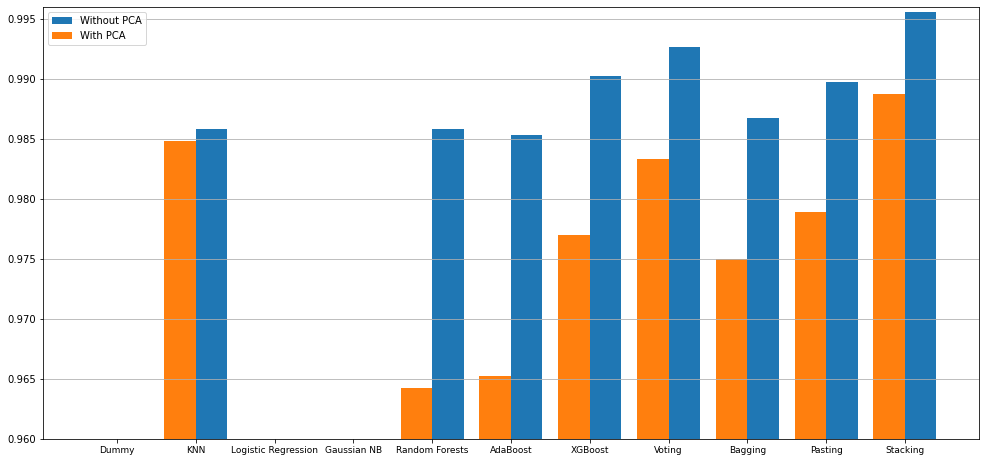

In [65]:
labels = ['Dummy', 'KNN', 'Logistic Regression', 'Gaussian NB', 'Random Forests', 'AdaBoost', 'XGBoost', 'Voting',
          'Bagging', 'Pasting', 'Stacking']
accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyGNB, accuracyRandForests, accuracyAdaBoost,
              accuracyXGBoost, accuracyVoting, accuracyBagging, accuracyPasting, accuracyStacking]
accuraciesPCA = [accuracyDummy, accuracyKNNPCA, accuracyLogRegPCA, accuracyGNBPCA, accuracyRandForestsPCA,
                 accuracyAdaBoostPCA, accuracyXGBoostPCA,accuracyVotingPCA, accuracyBaggingPCA, accuracyPastingPCA,
                 accuracyStackingPCA]
xpos = np.arange(len(labels))
fig = plt.figure(figsize=(13,6))
axes = fig.add_axes([0,0,1,1])
plt.xticks(xpos, labels)
axes.bar(xpos + 0.2, accuracies, label = 'Without PCA', width = 0.4)
axes.bar(xpos - 0.2, accuraciesPCA, label = 'With PCA', width = 0.4)
axes.set_ylim([0.96, 0.996])
plt.grid(axis = 'y')
plt.legend()

While plotting the runtime graph, we take a slightly different approach to the usual: due to low differences in runtime, while the runtimes themselves are quite long (in comparison), we shall plot not the runtimes themselves, but rather the difference in runtime between the classifiers which used PCA and the ones that did not. This presents us with a graph that is much easier to read.

While comparing the results of this graph to the graph above, we can conclude that the difference in accuracy of at least 0.5% improves the runtimes of the classifiers slightly (we will not consider the Bagging and Pasting classifiers as their accuracy is lower than other classifiers while their runtime is longer). While useful to some degree if the resources available are very limited, I believe that its usefulness is very limited, and so the PCA does not contribute to the classifiers, hence are to be discarded.

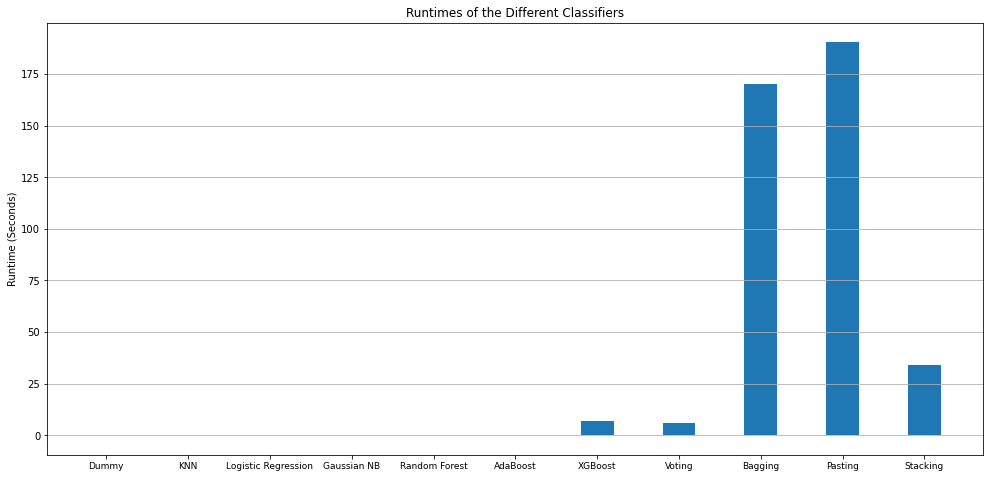

In [66]:
def timeGraph(time, labels):
    fig = plt.figure(figsize=(13,6))

    timeSize = np.arange(len(time))
    axes = fig.add_axes([0,0,1,1])
 #   labels = ['Dummy', 'KNN', 'Logistic Regression', 'Gaussian NB', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
 #             'Pasting', 'Stacking']
    axes.bar(labels, time, width = 0.4)
    axes.set_ylabel("Runtime (Seconds)")
    axes.set_title("Runtimes of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 9
    plt.grid(axis = 'y')

time = [timeDummy, timeKNN, timeLogReg, timeGNB, timeRandForests, timeAdaBoost, timeXGBoost, timeVoting, timeBagging,
        timePasting, timeStacking]
time = np.array(time)

timePCA = [timeDummy, timeKNNPCA, timeLogRegPCA, timeGNBPCA, timeRandForestsPCA, timeAdaBoostPCA, timeXGBoostPCA, timeVotingPCA,
           timeBaggingPCA, timePastingPCA, timeStackingPCA]
timePCA = np.array(timePCA)

difference = timePCA-time

labels = ['Dummy', 'KNN', 'Logistic Regression', 'Gaussian NB', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
          'Pasting', 'Stacking']
timeGraph(difference, labels)



As done in previous notebooks, we shall create a dataframe containing the results achieved by the classifiers. We shall include the results of PCA, but will disregard them, as explained above. Let’s consider the results to determine the best classifier out of the ones tried: The most accurate model was the Stacking Classifier, with an accuracy of 99.46% and a runtime of slightly more than 2.5 minutes. The second-best model in terms of accuracy was the XGBoost, with an accuracy of 99.01% and a runtime of 26 seconds (almost 27). The 3rd best classifier has a longer runtime than the XGBoost, thus shall not be considered. In my opinion, one more classifier has to be considered: the KNN, due to its spectacular runtime of 0.3 seconds and an accuracy of 98.53%. Nevertheless, the drop of 1% is too significant in my opinion, thus we shall not consider it best. The difference between Stacking and XGBoost is more subtle, but we can see that 0.4% of accuracy "costs" us more than 2 minutes of runtime, which is not insignificant, so I believe that the best model shall be considered the XGBoost Classifier.

In [68]:
results = pd.DataFrame(np.array([['Dummy', accuracyDummy, timeDummy, '---', '---'],
                                 ['KNN', accuracyKNN, timeKNN, accuracyKNNPCA, timeKNNPCA],
                                 ['Logistic Regression', accuracyLogReg, timeLogReg, accuracyLogRegPCA, timeLogRegPCA],
                                 ['Random Forests', accuracyRandForests, timeRandForests, accuracyRandForestsPCA,
                                  timeRandForestsPCA],
                                 ['Gaussian Naive Bayes', accuracyGNB, timeGNB, accuracyGNBPCA, timeGNBPCA],
                                 ['AdaBoost', accuracyAdaBoost, timeAdaBoost, accuracyAdaBoostPCA, timeAdaBoostPCA],
                                 ['XGBoost', accuracyXGBoost, timeXGBoost, accuracyXGBoostPCA, timeXGBoostPCA],
                                 ['Voting', accuracyVoting, timeVoting, accuracyVotingPCA, timeVotingPCA],
                                 ['Bagging', accuracyBagging, timeBagging, accuracyBaggingPCA, timeBaggingPCA],
                                 ['Pasting', accuracyPasting, timePasting, accuracyPastingPCA, timePastingPCA],
                                 ['Stacking', accuracyStacking, timeStacking, accuracyStackingPCA, timeStackingPCA]]),
                       columns=['Model', 'Accuracy', 'Runtime (Seconds)', 'Accuracy (PCA)', 'Runtime (Seconds) (PCA)'])

resultsView = results.sort_values(by = 'Accuracy', axis = 0, ascending = False)
resultsView = resultsView.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds),Accuracy (PCA),Runtime (Seconds) (PCA)
10,Stacking,0.9955882352941177,153.43012714385986,0.9887254901960785,187.3762562274933
7,Voting,0.9926470588235294,31.098904848098755,0.9833333333333333,36.83998155593872
6,XGBoost,0.9901960784313726,25.30731725692749,0.9769607843137255,32.07579851150513
9,Pasting,0.9897058823529412,675.0112235546112,0.9789215686274509,865.2716310024261
8,Bagging,0.986764705882353,619.7072765827179,0.975,789.8874773979187
1,KNN,0.9857843137254902,0.38295793533325195,0.9848039215686275,0.3638453483581543
3,Random Forests,0.9857843137254902,1.340663194656372,0.9642156862745098,1.5909209251403809
5,AdaBoost,0.9852941176470589,1.412658929824829,0.9651960784313726,1.6787350177764893
2,Logistic Regression,0.8769607843137255,0.4198775291442871,0.8691176470588236,0.40010547637939453
4,Gaussian Naive Bayes,0.8294117647058824,0.012970209121704102,0.8200980392156862,0.013974905014038086


## Semi-Conclusion

In this dataset, many changes can be done at every step to change, improve or worsen the data, whether in the classifiers, or in the preprocessing. For example, we made the decision to not include all records with the assumption that not much changes in terms of hand positioning of the subject in one frame. This assumption, however justified, only considers the way we perceive the data, but in no way does it mean that our PC, or more accurately, our classifiers, see it in the same way. Moreover, besides the optional play with hyperparameters of each model, we chose to remove 4 features with high correlation of data. Again, this was done with much thought behind the action, but it does not necessarily mean it was the right action to take. Below we will show some of the results received by such changes: these are not shown in code, as the different scenarios will take a lot of unneeded notebook space (all the code will be the same but for very minor changes). Also, not all variations are shown, but only to understand what we choose to use and why. This is run only on the best classifier as was determined above, XGBoost.

 - If we were to leave the four features which were removed due to high linear correlation, while not changing anything else, the accuracy would be 0.9926 and the runtime: 64.677 seconds.
<br><br>
<b>Siphoning of rows</b> (without further changes and with the removal of the 4 features):
 - Every single row remains: Accuracy: 0.9999019607843137; Time: 318.29862809181213 seconds
 - Every 3rd row remains: Accuracy: 0.9958823529411764; Time: 94.63196039199829 seconds
 - Every 5th row remains: Accuracy: 0.9916666666666667; Time: 52.821453332901 seconds
 - Every 10th row remains: Accuracy: 0.9823529411764705; Time: 23.10691738128662 seconds
 - Every 20th row remains: Accuracy: 0.9568627450980393; Time: 10.629583358764648 seconds

After these trials, we can see that the removal of the four features did not cost us much in terms of accuracy and improved our runtime by some amount of seconds. It is also obvious that leaving every single row in the data increases the runtime of the classifiers 6-fold, which is not a small amount of time, though it does give us a fabulous accuracy score of 99.99%. Leaving every 3rd row, however, boosts accuracy by 0.5% while increasing runtime by 40 seconds, which is, too, not a small amount, but I believe it is acceptable. Leaving every 10th or 20th record decreases the accuracy by more than 1%, which is in my opinion unacceptable, thus are removed from consideration.<br>
In conclusion of these trials, I believe the only question we have to ask ourselves is whether to leave every 3rd or 5th record in our data. It is a matter of perspective and needs of the project, but I shall choose to leave every 5th row of the dataframe as the best preprocessing technique.<br>
Note that the values are slightly different in the trials than in the dataframe created above. This is most likely due to CPU resource of the PC being more limited during the trials. Nevertheless, the ratio between the values should, in theory, remain unchanged.

### Trying something different

#### K-Means

The last thing we want to try before deciding to stay with our verdict or to change the models to that which will be momentarily described, is using K-Means Clustering as part of our preprocessing of the data.<br>
In general, the K-Means Clustering method is used for unsupervised learning, dividing the data into multiple clusters, as specified in the "n_clusters" hyperparameter. This is done, in short, by choosing the best starting points (centroids) of the clusters, and then classifying all remaining records to each one's closest centroid.

We can use this method, however, not only in unsupervised learning, but also as a part of the preprocessing and dimensionality reduction of the data. This is done by dividing the data into clusters, and the concatenation of each record's (from the original data) distance from each of the clusters forms a new dataset, on which the classifiers are run to fit and predict the labels of training and testing sets, respectively.

In [57]:
import time
start_timeKMeans = time.time()
pipeline = Pipeline([("kmeans", KMeans(n_clusters=20)), ("XGBoost", modelXGBoost),])
param_grid = dict(kmeans__n_clusters=range(3, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=2, verbose=2)
grid_clf.fit(X_train, y_train)
timeGridSearch = time.time() - start_timeKMeans
print('Best params:', grid_clf.best_params_)

Fitting 2 folds for each of 97 candidates, totalling 194 fits
[CV] END ...............................kmeans__n_clusters=3; total time=  28.0s
[CV] END ...............................kmeans__n_clusters=3; total time=  27.8s
[CV] END ...............................kmeans__n_clusters=4; total time=  19.8s
[CV] END ...............................kmeans__n_clusters=4; total time=  20.0s
[CV] END ...............................kmeans__n_clusters=5; total time=  19.7s
[CV] END ...............................kmeans__n_clusters=5; total time=  19.4s
[CV] END ...............................kmeans__n_clusters=6; total time=  18.0s
[CV] END ...............................kmeans__n_clusters=6; total time=  19.0s
[CV] END ...............................kmeans__n_clusters=7; total time=  17.6s
[CV] END ...............................kmeans__n_clusters=7; total time=  23.5s
[CV] END ...............................kmeans__n_clusters=8; total time=  17.7s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=53; total time=  40.0s
[CV] END ..............................kmeans__n_clusters=54; total time=  38.8s
[CV] END ..............................kmeans__n_clusters=54; total time=  41.2s
[CV] END ..............................kmeans__n_clusters=55; total time=  38.9s
[CV] END ..............................kmeans__n_clusters=55; total time=  39.2s
[CV] END ..............................kmeans__n_clusters=56; total time=  39.0s
[CV] END ..............................kmeans__n_clusters=56; total time=  40.2s
[CV] END ..............................kmeans__n_clusters=57; total time=  40.8s
[CV] END ..............................kmeans__n_clusters=57; total time=  41.9s
[CV] END ..............................kmeans__n_clusters=58; total time=  41.4s
[CV] END ..............................kmeans__n_clusters=58; total time=  44.3s
[CV] END ..............................kmeans__n_clusters=59; total time=  43.0s
[CV] END ...................

In [70]:
import time
start_timeKMeans = time.time()
pipeline = Pipeline([("kmeans", KMeans(n_clusters=98)), ("XGBoost", modelXGBoost)])
pipeline.fit(X_train, y_train)
accuracykMeansXGBoost = pipeline.score(X_test, y_test)

print("Accuracy (K-Means XGBoost): ", accuracykMeansXGBoost)
timeKMeans = time.time() - start_timeKMeans
print("Time taken to achive result: %s seconds" % (timeKMeans))

Accuracy (K-Means XGBoost):  0.9436274509803921
Time taken to achive result: 161.23521280288696 seconds


We can see that even running grid search, which took a long amount of time, the k-means, although producing a good result, cannot compare to the other classifiers shown above.

#### Multiplication

Let us remember the way we united the left and right hands from being on 2 separate lines into 1: we moved the bottom row up to stand beside the upper row, so the number of original features doubled, while the number of rows halved. Let us try to change this, and instead of moving the row up, we shall multiply each value of the left hand by its counterpart in the right hand (excluding the label, of course. This is done with the knowledge, the assumption, and the hope that during different stages in the experiment (sync, spont, alone) the hands recorded have different characteristics (as a pair), having different correlations between them. To check these correlations, and so that both hands "participate" in the final dataframe, we shall multiply the values. This test shall be run only on the best classifier, which , as will be decided below, is the XGBoost Classifier. No explanations will be given as the code is practically identical to that which has already been explained.<br>
Moreover, such a method could help us improve our problem of overfitting and bias towards similar data, as even a small change in one value can cause a much bigger change in the multiplication of said value by another.

The data has 15 features


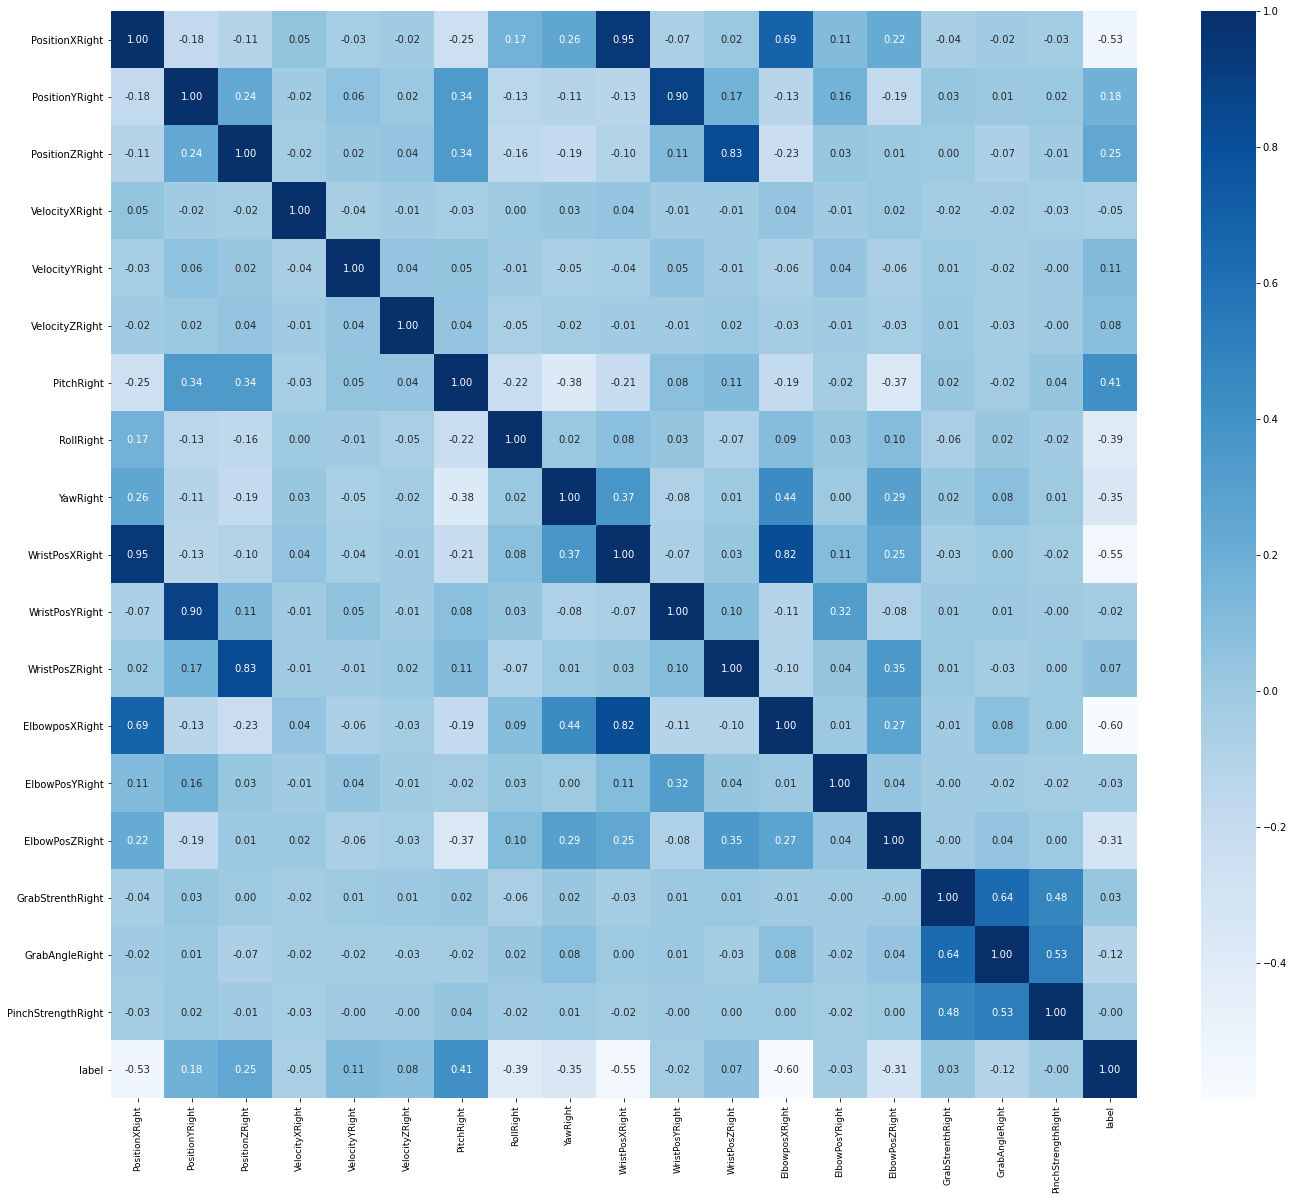

In [71]:
#import of dfs from .csv
fulldf = pd.read_csv('Data/Hand Positioning/df.csv')
fulldf = fulldf.drop(['Unnamed: 0'], axis = 1)
fulldfTest = pd.read_csv('Data/Hand Positioning/dfTest.csv')
fulldfTest = fulldfTest.drop(['Unnamed: 0'], axis = 1)


#Removal of unnecessary features
fulldf = fulldf.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldf = fulldf.rename(columns={'labelLeft': 'label'})

fulldfTest = fulldfTest.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldfTest = fulldfTest.rename(columns={'labelLeft': 'label'})


#Multiplying the values. As there are 18 values for each hand, the for loop runs 18 times
for i in range(18):
    fulldf.iloc[:, i] = fulldf.iloc[:, i] * fulldf.iloc[:, i+18]
for i in range(18):
    fulldfTest.iloc[:, i] = fulldfTest.iloc[:, i] * fulldfTest.iloc[:, i+18]
    

#Removing the features after they have been used
for i in range(18, 36):
    fulldf = fulldf.drop(fulldf.columns[18], axis=1)
for i in range(18, 36):
    fulldfTest = fulldfTest.drop(fulldfTest.columns[18], axis=1)
    

#Leaving every 5th row
fulldf = fulldf.iloc[::5, :]
fulldf = fulldf.reset_index() #resetting index of the fulldf
fulldf = fulldf.drop(['index'], axis = 1)

fulldfTest = fulldfTest.iloc[::5, :]
fulldfTest = fulldfTest.reset_index() #resetting index of the fulldfTest
fulldfTest = fulldfTest.drop(['index'], axis = 1)


#Correlation graph
plt.figure(figsize=(23,20))
sns.heatmap(fulldf.corr(), cmap = 'Blues', annot=True, fmt=".2f")


#Removing more unnecessary features according to correlation graph
fulldf['WristPosXRight'] = fulldf['WristPosXRight'] * fulldf['PositionXRight'] * fulldf['ElbowposXRight']
fulldf['PositionYRight'] = fulldf['PositionYRight'] * fulldf['WristPosYRight']

fulldfTest['WristPosXRight'] = fulldfTest['WristPosXRight'] * fulldfTest['PositionXRight'] * fulldfTest['ElbowposXRight']
fulldfTest['PositionYRight'] = fulldfTest['PositionYRight'] * fulldfTest['WristPosYRight']

fulldf = fulldf.drop(['PositionXRight', 'ElbowposXRight', 'WristPosYRight'], axis = 1) #Further unneeded attributes
fulldfTest = fulldfTest.drop(['PositionXRight', 'ElbowposXRight', 'WristPosYRight'], axis = 1) #Further unneeded attributes


#Dividing data for split
x = fulldf.drop(['label'], axis = 1)
y = fulldf['label']

X_test_final = fulldfTest.drop(['label'], axis = 1)
y_test_final = fulldfTest['label']


#Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)


#Scaling
X_train, X_test, X_test_final = scale(X_train, X_test, X_test_final)

print("The data has", len(X_train.columns), "features")

<a id='multiplication'></a>

Accuracy (XGBoost):  0.9602941176470589
Time taken to achive result: 26.579944849014282 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       634
           1       0.94      0.95      0.95       722
           2       0.95      0.94      0.94       684

    accuracy                           0.96      2040
   macro avg       0.96      0.96      0.96      2040
weighted avg       0.96      0.96      0.96      2040



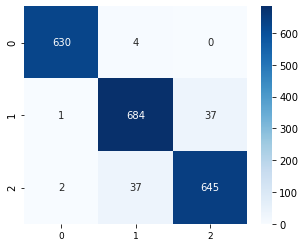

In [72]:
modelXGBoost, predictionsXGBoost, accuracyXGBoost, timeXGBoost = XGBoost(X_train, y_train, X_test, y_test)

## Best Classifier

Throughout this notebook, we have tried many different methods for preprocessing, classification and analyzing the datasets we have been provided. We tried some different ways for preprocessing the data, as well as many different classifiers to predict data. Note that Grid Search was not run on the hyperparameters of the classifiers due to its long runtime, but "manual grid search" was run by trying different combinations of hyperparameters. By analyzing these methods, we can now determine which classifiers and methods for preprocessing work best for this dataset (out of the methods we have tested). As always, the question of which classifier to choose depends on the resources and the hardware available, as well as on the desired accuracy (if such exists):

If the accuracy of the classifier were to be our only concern, then the XGBoost classifier we have shown, run on the dataframe while taking every single row of the data (without siphoning) will, at first glance, be the best choice. Its accuracy of 99.99% is surpassed by no other, with the runtime of 5 minutes. My theory (though untested due to longer runtime) is that the Stacking Classifier shown above would probably give even better results if it were to be run on un-siphoned data. But if we were to think about why these classifiers are so good, we conclude that the classifiers simply overfit the existing data to the very near similarities to their neighbors. For example, a certain record is chosen to be on the training set, and the one after that is chosen for the test set. The difference between the two records is almost nonexistent, and while training on the one, the classifier can barely make a mistake on the other while predicting. Thus, these models are overfitted, and are not the best ones for real world data.

If the resources available were very limited, then the KNN Classifier would be a good choice, with its accuracy of 98.52% and the runtime of 0.366 seconds.

Finally, if a balance between the 2 extremes was desired, then the question is slightly harder. The XGBoost on siphoned data (leaving every 5th row) will be an excellent choice for balance between accuracy and runtime, having the accuracy of 99% and a runtime of 26 seconds. Again, the problem of overfitting arises, but in my opinion, every 5th entry should have enough of a difference to matter to a lesser extent.

Next, we must examine our latest test with a different approach to preprocessing by multiplying the values of each pair of hands for each feature (The [cell](#multiplication) before this section). Its accuracy is 96.02% with the runtime of 27 seconds, but what is unique about this classifier is that it uses only 15 features to achieve its result (compared to 32 in the case of all the rest). This, in my opinion, gives a significant boost to its importance and its value due to its efficiency, even to the point where I believe it to be better than all other classifiers discussed up until now.

We will count the last XGBoost Classifier with the use of multiplication as best for our data with the accuracy of 96.02%, the runtime of 27 seconds and using 15 features

## Final Predict

Now that we have chosen our best classifier using our training and validation sets, with the hyperparameter tuning being done on the validation set, we can now try and test how the classifier will react to previously unseen data, for which the model was not specifically tuned. This will give us an inclination of how the classifier will perform on real life data. Results will be explained and interpreted in the conclusion below.

In [73]:
predictionsXGBoost = modelXGBoost.predict(X_test_final)
accuracyXGBoost = metrics.accuracy_score(y_test_final, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)

Accuracy (XGBoost):  0.8491944859657864


## Conclusion

After using our best classifier on previously unseen data, I was very surprised to see the results: 84.91% accuracy with a similar runtime of 26 seconds compared to the original model. But 84.91% is a drop of more than 12% from the original 96.02%, that is a prodigious drop. Upon further examination, and as mentioned above, we can theorize as to the reasons for such a drop: when leaving every 5th row in our dataset, we still could not create totally unrelated data, thus the fitting of our classifiers was done not totally unbiased, as the data was still relatively close to one another. However, 84.45% is still a good accuracy, especially considering we used only 15 features to achieve the result.